## **Construction d'un algorithme de prédiction du nombre d'observations pour les mois à venir**

Données extaites du site iNaturalist.org : https://www.inaturalist.org/pages/developers - http://www.inaturalist.org/observations/gbif-observations-dwca.zip

1er traitement des données fait sur KNIME (data preparation) :

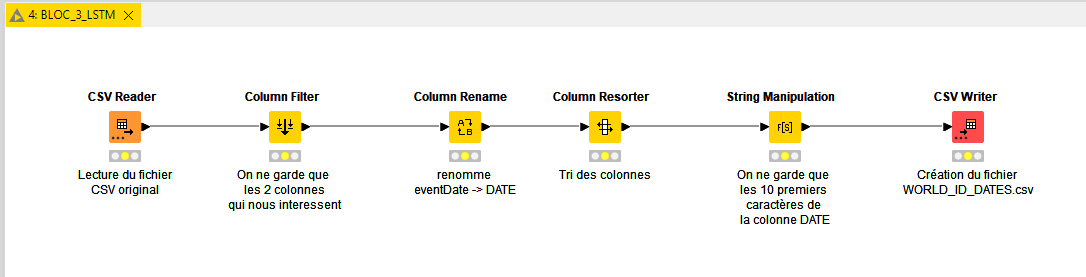

## 1. Imports bibliothèques python

In [11]:
import numpy as np
import pandas as pd

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

import matplotlib.pyplot as plt


## 2. Import, compréhension et transformation des données
Data preparation

In [18]:
#Import du fichier généré via KNIME avec 2 colonnes : DATE et id
df = pd.read_csv('WORLD_ID_DATES.csv') 

In [6]:
# A quoi ressemble notre dataset ?
# Un index de 0 à 68755814, une colonne DATE au format AAAA-MM-JJ et une colonne id
print(df)

                DATE         id
0         2022-08-31  133060946
1         2022-08-24  133060959
2         2022-08-31  133060960
3         2022-08-31  133060970
4         2022-08-31  133060971
...              ...        ...
68755810  2019-04-06   22176809
68755811  2019-04-04   22176815
68755812  2019-04-05   22176817
68755813  2019-04-07   22176823
68755814  2017-05-20   22176824

[68755815 rows x 2 columns]


In [15]:
# Je vérifie que tous les id sont bien uniques --> c'est bien le cas
df['id'].nunique()


68755815

In [19]:
df.info()

# La colonne DATE est de type Objet et la colonne id de type int64

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68755815 entries, 0 to 68755814
Data columns (total 2 columns):
 #   Column  Dtype 
---  ------  ----- 
 0   DATE    object
 1   id      int64 
dtypes: int64(1), object(1)
memory usage: 1.0+ GB


On sait, car il est précisé dans la sources des données, que ces données sont de type "grade Recherche", qui est un indicateur de qualité tenu par le site iNaturalist, et on peut donc les considérer fiables.
Il ne faut déterminer que la plage de dates à prendre en compte pour pouvoir créer cet algorithme avec fiabilité

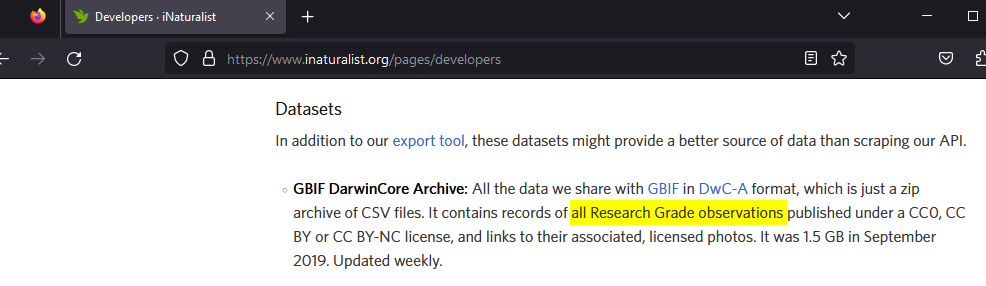

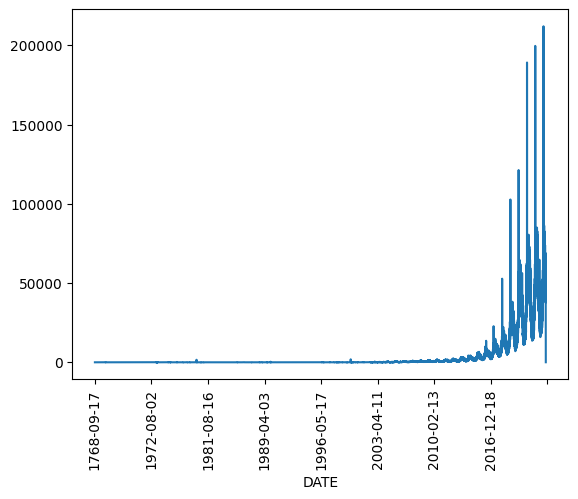

In [20]:
#première représentation graphique des données 

df_graph = df.groupby(['DATE'])['id'].count()
fig, ax = plt.subplots()

# Tracez le graphe en utilisant la série df
df_graph.plot(ax=ax)

# Faites pivoter les étiquettes des années sur l'axe des abscisses à 90 degrés
plt.xticks(rotation=90)

# Affichez le graphe
plt.show()

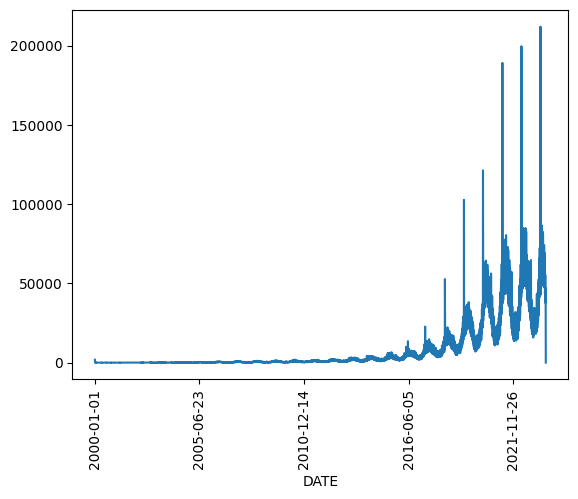

In [23]:
#J'enlève toutes les valeurs abhérentes ou très peu significatives avant les années 2000
#Et je le regarde de nouveau graphiquement

df_recherches_dates = df.loc[df['DATE'] >= '2000-01-01']
df_recherches_dates_graph = df_recherches_dates.groupby(['DATE'])['id'].count()
fig, ax = plt.subplots()

# Tracez le graphe en utilisant la série df
df_recherches_dates_graph.plot(ax=ax)

# Faites pivoter les étiquettes des années sur l'axe des abscisses à 90 degrés
plt.xticks(rotation=90)

# Affichez le graphe
plt.show()



In [24]:
# J'affine ce que j'avais trouvé précédemment : je décide de prendre les données à partir de l'années 2017
df = df.loc[df['DATE'] >= '2017-01-01']

#Les données seront regroupées par mois. Comme j'ai téléchargé le dataset au mois d'août, il n'est pas 
#complet pour le mois d'août 2023. Je décide d'arrêter les données au 31/072023
df = df.loc[df['DATE'] <= '2023-07-31']

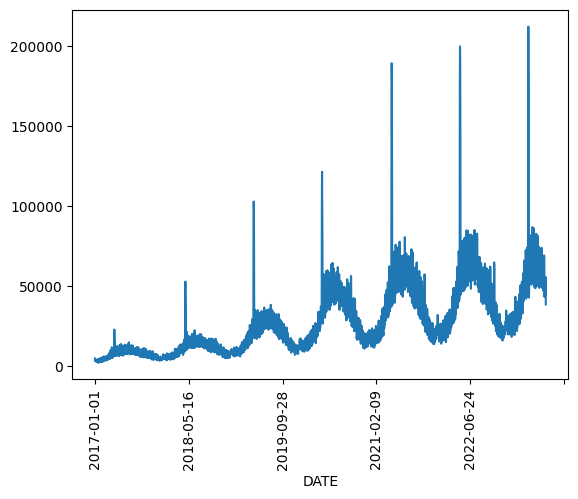

In [25]:
# J'affiche de nouveau le graph après ces données


df_graph = df.groupby(['DATE'])['id'].count()
fig, ax = plt.subplots()

# Tracez le graphe en utilisant la série df
df_graph.plot(ax=ax)

# Faites pivoter les étiquettes des années sur l'axe des abscisses à 90 degrés
plt.xticks(rotation=90)

# Affichez le graphe
plt.show()

In [26]:
# Je trie les données du dataset
df.sort_values("DATE",inplace=True)



In [27]:
# Pour pouvoir exploiter les données par mois et prédire le nombre d'observations sur les mois suivants,
# je ne garde qu'une date, le 1er du mois, pour toutes les données du mois en cours
# Par ex, une observation faite le 06/05/2023 aura après le traitement une date de 01/05/2023 
df['DATE'] = pd.to_datetime(df['DATE'])
df['DATE'] = df['DATE'].dt.to_period('M').dt.to_timestamp()



In [28]:
# Maintenant que toutes les dates du mois sont regroupées sous une date unique, je 
# peux compter le nombre d'occurence d'obsservations par mois 

df = df.groupby(['DATE'])['id'].count()




In [30]:
print(df)

DATE
2017-01-01     101635
2017-02-01     108537
2017-03-01     163040
2017-04-01     282262
2017-05-01     262845
               ...   
2023-03-01    1068408
2023-04-01    1980261
2023-05-01    1994896
2023-06-01    1776404
2023-07-01    1679274
Name: id, Length: 79, dtype: int64


In [31]:
# le dataframe est maintenant une Series Pandas. Je le re transforme en dataframe et 
# renomme la colonne 'id' en 'nb' pour mieux refléter son contenu

print("Avant transformation en DataFrame : ", type(df))

df = pd.DataFrame(df)

print("Après transformation en DataFrame : ", type(df))

df.rename(columns={'id':'nb'}, inplace=True)


Avant transformation en DataFrame :  <class 'pandas.core.series.Series'>
Après transformation en DataFrame :  <class 'pandas.core.frame.DataFrame'>


In [33]:
# Visualisation du Dataframe df
# On remarque que la colonne DATE est maintenant en index du dataframe suites aux transformations.
# C'est bien ce que l'on recherche pour la suite de l'exploitation des données

df

,nb
DATE,
2017-01-01,101635
2017-02-01,108537
2017-03-01,163040
2017-04-01,282262
2017-05-01,262845
...,...
2023-03-01,1068408
2023-04-01,1980261
2023-05-01,1994896


In [34]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 79 entries, 2017-01-01 to 2023-07-01
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   nb      79 non-null     int64
dtypes: int64(1)
memory usage: 1.2 KB


<Axes: xlabel='DATE'>

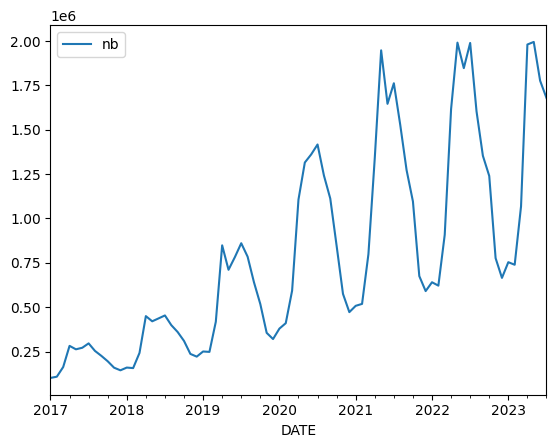

In [35]:
df.plot()

## 3. Split des données en données d'entraînement et données de test

In [38]:
test_len = 18 # On considère que les 18 derniers mois constitueront nos données de test et les reste avant seront nos données d'entraînement

ind = len(df) - test_len
train = df[:ind] #train : toutes les données sauf les 18 derniers mois
test = df[ind:] #test : les 18 derniers mois

print(f'Longueur du dataset train : {len(train)}')
print(f'Longueur du dataset test : {len(test)}')


Longueur du dataset train : 61
Longueur du dataset test : 18


In [39]:
#a quoi ressemble notre ensemble de test ?
test

,nb
DATE,
2022-02-01,621670
2022-03-01,908245
2022-04-01,1616383
2022-05-01,1990985
2022-06-01,1847225
2022-07-01,1989173
2022-08-01,1603900
2022-09-01,1353370
2022-10-01,1239722


In [40]:
# Mise à l'échelle des données test et train avec MinMaxScaler()
sc = MinMaxScaler()
train_sc = sc.fit_transform(train)
test_sc = sc.transform(test)

In [41]:
# La mise à l'échelle des données transforme les données en nombre décimaux entre 0 et 1 pour une facilité de traitement
#Il faudra donc bien évidemment faire l'opération inverse après traitement

#La mise à l'échelle s'est faite avec les données train_sc, puis appliquée également sur les données test_sc.
# C'est pour cela qu'on peut trouver des données supérieures à 1 dans test_sc (pour les données plus grandes que la max des données présente dans train)
test_sc

array([[0.28173154],
       [0.43698496],
       [0.82062223],
       [1.02356472],
       [0.94568202],
       [1.02258306],
       [0.8138595 ],
       [0.67813363],
       [0.61656427],
       [0.36561633],
       [0.30538564],
       [0.35330657],
       [0.34543   ],
       [0.52375406],
       [1.01775493],
       [1.02568352],
       [0.9073144 ],
       [0.85469374]])

## 4. Construire train et test generators

Comme on a ici une seule série, qui sera à la fois les données de départ (sur 12 mois, X) et la résultante (le mois suivant, y), il faut construire pour les 2 datasets de données, 

In [42]:
#on prend 12 données (sequence_length) pour prédire la prochaine donnée (out_len))

sequence_length = 12 
out_len = 1

# Train Generator
train_gen = TimeseriesGenerator(data = train_sc,
                                targets = train_sc,
                                length = sequence_length,
                                batch_size = out_len)

# Test Generator
test_gen = TimeseriesGenerator(data = test_sc,
                                targets = test_sc,
                                length = sequence_length,
                                batch_size = out_len)

In [46]:
print(f'Length of Train set: {len(train)}')
print(f'Length of Train Generator:{len(train_gen)}') # Note: Generator will exclude last "inp_len (12)" points.
print(f'Length of Test set: {len(test)}')
print(f'Length of Test Generator:{len(test_gen)}')

Length of Train set: 61
Length of Train Generator:49
Length of Test set: 18
Length of Test Generator:6


Explication des données obtenues suite à l'utilisation de TimeseriesGenerator

In [47]:
X, y = train_gen[0] # First gen object
print(f'First train_gen object input (X): {len(X[0])}\n {X}\n') # 'inp_len' data points
print(f'First train_gen object output (y): {len(y[0])}\n {y}') # 'out_len' data points

First train_gen object input (X): 12
 [[[0.        ]
  [0.00373919]
  [0.03326646]
  [0.09785557]
  [0.08733632]
  [0.09205879]
  [0.10545802]
  [0.08241176]
  [0.06736398]
  [0.05087458]
  [0.0312533 ]
  [0.02322774]]]

First train_gen object output (y): 1
 [[0.03162115]]


In [43]:
print(train_gen[0])
# Renvoie 2 array -> 
# le premier : la série de 12 valeurs utilisées pour rédire la valeur du mois suivant qui est dans le deuxième array renvoyé



(array([[[0.        ],
        [0.00373919],
        [0.03326646],
        [0.09785557],
        [0.08733632],
        [0.09205879],
        [0.10545802],
        [0.08241176],
        [0.06736398],
        [0.05087458],
        [0.0312533 ],
        [0.02322774]]]), array([[0.03162115]]))


## 5. Construction du modèle LSTM

In [44]:
# Construction du modèle LSTM
model = Sequential()
model.add(LSTM(150, activation='relu', input_shape=(sequence_length, 1)))

#ajout d'une couche de droput pour éviter l'overfitting :
model.add(Dropout(0.30)) 

model.add(Dense(1))


model.compile(optimizer='adam', loss='mse')

In [45]:
# Entraînement du modèle

model.fit(train_gen, validation_data=test_gen, epochs=100)


Epoch 1/100
49/49 [==============================] - 1s 6ms/step - loss: 0.0561 - val_loss: 0.0617
Epoch 2/100
49/49 [==============================] - 0s 3ms/step - loss: 0.0450 - val_loss: 0.0566
Epoch 3/100
49/49 [==============================] - 0s 3ms/step - loss: 0.0442 - val_loss: 0.0620
Epoch 4/100
49/49 [==============================] - 0s 3ms/step - loss: 0.0369 - val_loss: 0.0931
Epoch 5/100
49/49 [==============================] - 0s 3ms/step - loss: 0.0352 - val_loss: 0.0755
Epoch 6/100
49/49 [==============================] - 0s 3ms/step - loss: 0.0334 - val_loss: 0.0371
Epoch 7/100
49/49 [==============================] - 0s 3ms/step - loss: 0.0429 - val_loss: 0.1999
Epoch 8/100
49/49 [==============================] - 0s 3ms/step - loss: 0.0428 - val_loss: 0.0510
Epoch 9/100
49/49 [==============================] - 0s 3ms/step - loss: 0.0263 - val_loss: 0.0449
Epoch 10/100
49/49 [==============================] - 0s 3ms/step - loss: 0.0204 - val_loss: 0.0203
Epoch 11/

In [48]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 150)               91200     
                                                                 
 dropout (Dropout)           (None, 150)               0         
                                                                 
 dense (Dense)               (None, 1)                 151       
                                                                 
Total params: 91,351
Trainable params: 91,351
Non-trainable params: 0
_________________________________________________________________


In [50]:
# Liste vide pour stocker les prédictions :
y_pred = [] 

# 12 dernières données d'entraînement pour prédire la suivante :
train_sc_lastrows = train_sc[-sequence_length:] 

# Reshape (1, 12, 1)
batch = train_sc_lastrows.reshape((1, sequence_length, 1)) 

for _ in range(len(test)): 
  pred = model.predict(batch) #Prédiction
  y_pred.append(pred[0]) # Ajout de la prédiction à la liste
  batch = np.append(batch[:,1:,:],[pred],axis=1) # On enlève le premier element de 'batch', on ajoute notre nouvelle prédiction à la fin, et on refait une prochaine prédiction.

1/1 [==============================] - 0s 12ms/step


In [54]:
y_pred

[array([0.28391165], dtype=float32),
 array([0.6086476], dtype=float32),
 array([0.9129907], dtype=float32),
 array([1.0062629], dtype=float32),
 array([0.983503], dtype=float32),
 array([0.94654965], dtype=float32),
 array([0.84962744], dtype=float32),
 array([0.7441603], dtype=float32),
 array([0.6054276], dtype=float32),
 array([0.41018385], dtype=float32),
 array([0.33359325], dtype=float32),
 array([0.3095065], dtype=float32),
 array([0.43054283], dtype=float32),
 array([0.7840453], dtype=float32),
 array([0.9739428], dtype=float32),
 array([1.0221962], dtype=float32),
 array([1.0041256], dtype=float32),
 array([0.95178604], dtype=float32)]

In [56]:
# On enlève la mise à l'échelle -> revenir à nos données de départ
y_pred = sc.inverse_transform(y_pred) 
#Ajout des prdiction à notre data set test de départ pour comparaison :
test['y_pred'] = y_pred 



C:\Users\Pauline\AppData\Local\Temp\ipykernel_9952\3453921221.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['y_pred'] = y_pred


In [55]:
y_pred

[array([0.28391165], dtype=float32),
 array([0.6086476], dtype=float32),
 array([0.9129907], dtype=float32),
 array([1.0062629], dtype=float32),
 array([0.983503], dtype=float32),
 array([0.94654965], dtype=float32),
 array([0.84962744], dtype=float32),
 array([0.7441603], dtype=float32),
 array([0.6054276], dtype=float32),
 array([0.41018385], dtype=float32),
 array([0.33359325], dtype=float32),
 array([0.3095065], dtype=float32),
 array([0.43054283], dtype=float32),
 array([0.7840453], dtype=float32),
 array([0.9739428], dtype=float32),
 array([1.0221962], dtype=float32),
 array([1.0041256], dtype=float32),
 array([0.95178604], dtype=float32)]

In [57]:
test

,nb,y_pred
DATE,,
2022-02-01,621670,6.256942e+05
2022-03-01,908245,1.225109e+06
2022-04-01,1616383,1.786882e+06
2022-05-01,1990985,1.959048e+06
2022-06-01,1847225,1.917037e+06
2022-07-01,1989173,1.848827e+06
2022-08-01,1603900,1.669922e+06
2022-09-01,1353370,1.475246e+06
2022-10-01,1239722,1.219165e+06


<Axes: xlabel='DATE'>

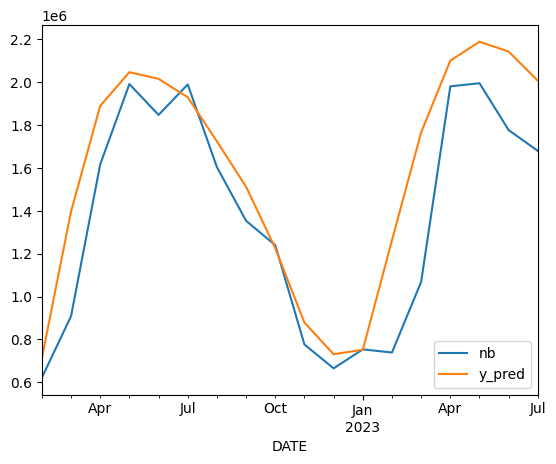

In [181]:
test.plot() 

In [60]:
rmse = mean_squared_error(test['nb'],test['y_pred'])**0.5
df_mean = df['nb'].mean()
print(f'RMSE : {rmse}')
print(f'Mean : {df_mean}')
print(f'Scatter Index: {rmse/df_mean}') # Less SI -> Better Model

RMSE : 169457.82125879126
Mean : 795143.8607594937
Scatter Index: 0.2131159273454379


## 6. Utilisation du modèle pour prédiction des 24 prochains mois

In [62]:
# Mise à l'échelle du dataset

sc = MinMaxScaler()
df_sc = sc.fit_transform(df)


In [186]:
df_sc

array([[0.        ],
       [0.00364556],
       [0.03243346],
       [0.09540523],
       [0.08514938],
       [0.08975361],
       [0.10281731],
       [0.08034814],
       [0.06567716],
       [0.04960066],
       [0.03047071],
       [0.02264611],
       [0.03082935],
       [0.02925006],
       [0.07438119],
       [0.18392657],
       [0.16851876],
       [0.17716258],
       [0.18595429],
       [0.15710195],
       [0.13664888],
       [0.11007938],
       [0.07145502],
       [0.06337267],
       [0.07865793],
       [0.07748483],
       [0.167071  ],
       [0.39454676],
       [0.32185631],
       [0.35958486],
       [0.4008919 ],
       [0.36092224],
       [0.28476845],
       [0.21979062],
       [0.13413576],
       [0.11566498],
       [0.14669874],
       [0.16292154],
       [0.25980676],
       [0.53075725],
       [0.64108277],
       [0.66519989],
       [0.69473094],
       [0.60265436],
       [0.53396653],
       [0.39301026],
       [0.25010128],
       [0.195

In [63]:
interval = 24 # Forecasting Period
sequence_length = 12
forecast = []
sc_df_lastrows = df_sc[-sequence_length:]
batch1 = sc_df_lastrows.reshape((1, sequence_length, 1))

In [64]:
sc_df_lastrows

array([[0.79348014],
       [0.6611529 ],
       [0.60112525],
       [0.35646115],
       [0.29773866],
       [0.34445964],
       [0.3367803 ],
       [0.51063905],
       [0.99226995],
       [1.        ],
       [0.88459489],
       [0.83329187]])

In [65]:
batch1

array([[[0.79348014],
        [0.6611529 ],
        [0.60112525],
        [0.35646115],
        [0.29773866],
        [0.34445964],
        [0.3367803 ],
        [0.51063905],
        [0.99226995],
        [1.        ],
        [0.88459489],
        [0.83329187]]])

In [66]:
for _ in range(interval):
  pred1 = model.predict(batch1)
  forecast.append(pred1[0]) 
  batch1 = np.append(batch1[:,1:,:],[pred1],axis=1)


1/1 [==============================] - 0s 14ms/step


In [67]:
forecast

[array([0.8480216], dtype=float32),
 array([0.7648332], dtype=float32),
 array([0.6469576], dtype=float32),
 array([0.44910508], dtype=float32),
 array([0.3645494], dtype=float32),
 array([0.35598484], dtype=float32),
 array([0.4505515], dtype=float32),
 array([0.8019664], dtype=float32),
 array([0.9877543], dtype=float32),
 array([0.9857077], dtype=float32),
 array([0.93837374], dtype=float32),
 array([0.90920126], dtype=float32),
 array([0.8675275], dtype=float32),
 array([0.78463733], dtype=float32),
 array([0.6614878], dtype=float32),
 array([0.4965579], dtype=float32),
 array([0.39553297], dtype=float32),
 array([0.39426786], dtype=float32),
 array([0.6311943], dtype=float32),
 array([0.87762475], dtype=float32),
 array([0.9769902], dtype=float32),
 array([0.9786475], dtype=float32),
 array([0.9524145], dtype=float32),
 array([0.9168416], dtype=float32)]

In [68]:
forecast = sc.inverse_transform(forecast)


forecast

array([[1707161.2725569 ],
       [1549663.89159274],
       [1326494.54781574],
       [ 951908.1403299 ],
       [ 791822.15860629],
       [ 775607.20813659],
       [ 954646.60210371],
       [1619966.76287436],
       [1971711.66600865],
       [1967836.94628781],
       [1878221.41386265],
       [1822990.29500401],
       [1744090.95357752],
       [1587158.25974882],
       [1354004.08734822],
       [1041748.68997091],
       [ 850482.1380986 ],
       [ 848086.95735317],
       [1296650.5393042 ],
       [1763207.71206975],
       [1951332.48645639],
       [1954470.08859754],
       [1904804.25260448],
       [1837455.49399912]])

In [69]:
# Création d'un nouveau dataframe avec les dates futures
fc_index = pd.date_range(start='2023-08-01', periods=interval, freq='MS')
fc_df = pd.DataFrame(forecast, index=fc_index, columns=['forecast'])

In [70]:
fc_df # Forecast Dataframe

,forecast
2023-08-01,1.707161e+06
2023-09-01,1.549664e+06
2023-10-01,1.326495e+06
2023-11-01,9.519081e+05
2023-12-01,7.918222e+05
2024-01-01,7.756072e+05
2024-02-01,9.546466e+05
2024-03-01,1.619967e+06
2024-04-01,1.971712e+06
2024-05-01,1.967837e+06


<Axes: xlabel='DATE'>

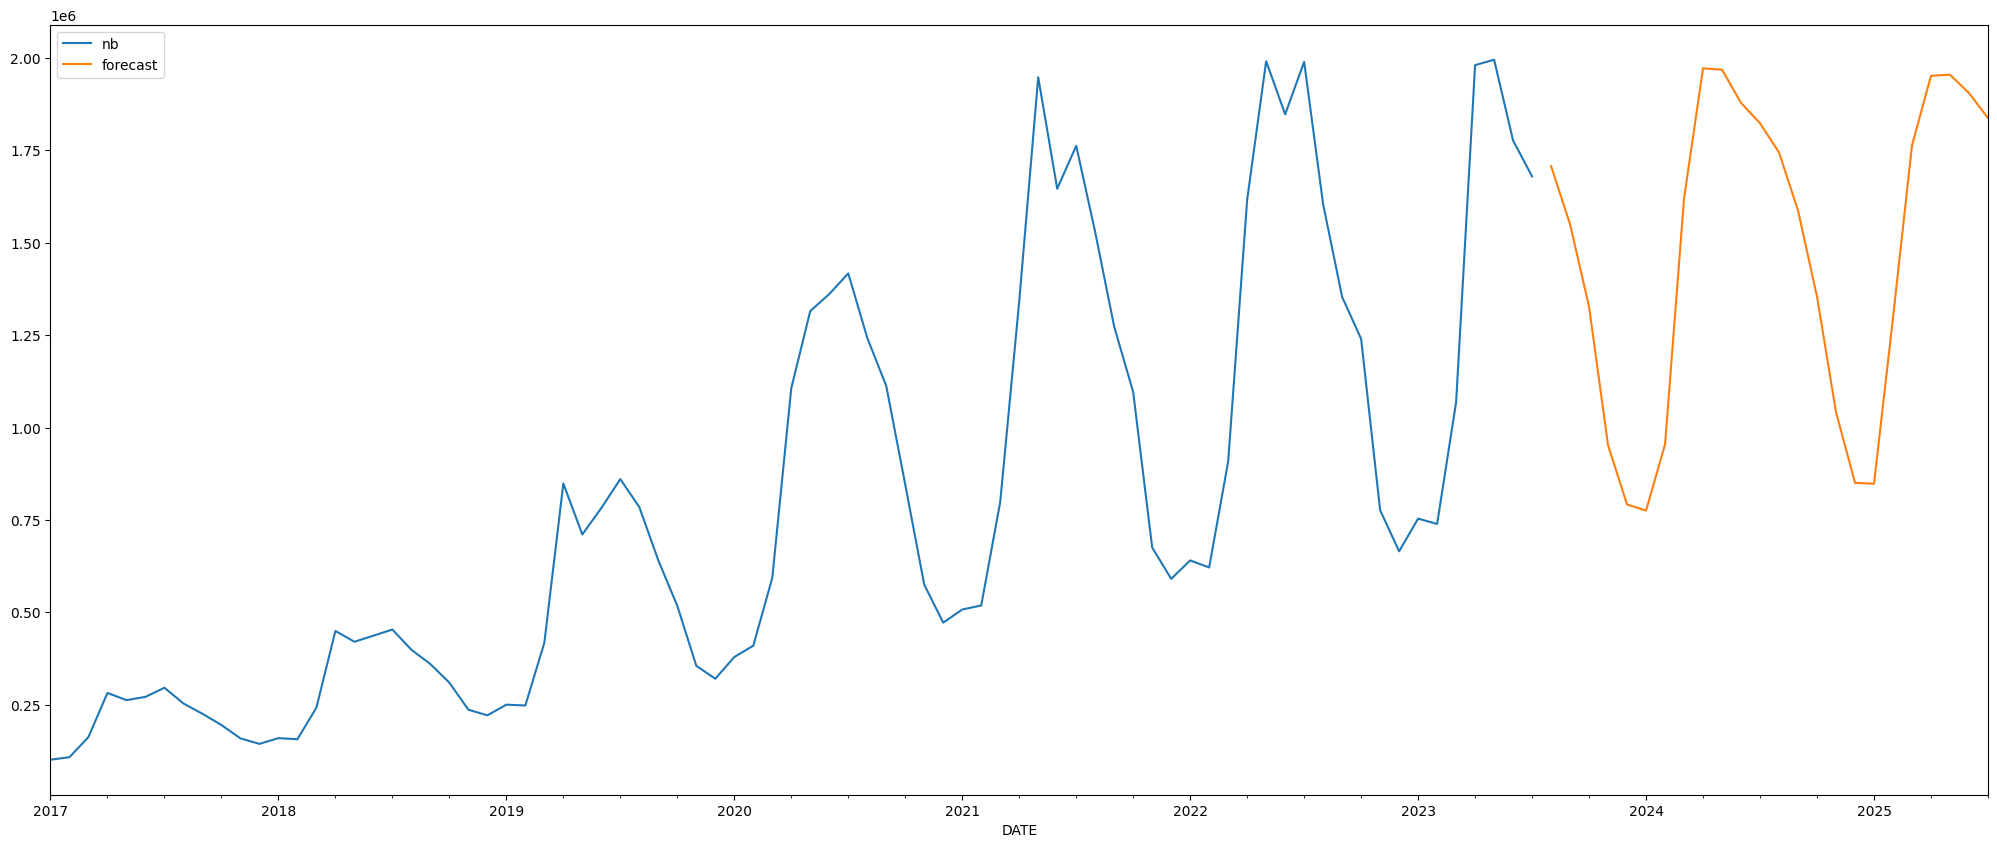

In [71]:
# Complete Graph with Forecasting
ax = df.plot()
fc_df.plot(ax=ax, figsize=(25,10))